# Block Diagonalization 

Now we will study a new Hamiltonian which has nearest neighbor interactions and off-diagonal elements but uses spin operators and includes the $S^{y}$ operator. 

$H = -\Delta\sum_{\langle i j \rangle} S_{i}^{z}S_{j}^{z} - J_{\perp}\sum_{\langle i j \rangle}\left( S_{i}^{x}S_{j}^{x} + S_{i}^{y}S_{j}^{y}\right)$

In this problem, we will take advantage of "conserved symmetry" of the Hamiltonian. Our diagonalization will only act on blocks of the Hamiltonian where the total $S^{z}$ is conserved.

# Step 1: Build the (full) Hamiltonian

In [1]:
using SparseArrays

function Hamiltonian_Prob2(N,Delta,J_perp)
    
    dim = (2)^N
    H = zeros(dim,dim)
    magz = zeros(dim)
    
    for ket in (0:dim-1)
        
        ket_binary = bitstring(ket)
        Diagonal = Int64(0)
        
        for SpinIndex in (0:N-1) 
            
            magz[ket+1] += 2*((ket>>SpinIndex)&1)-1
            
            if SpinIndex == N-1
                
                bit_last = Int(2)^(SpinIndex)
                bit_first = Int(2)^(0)
                flipbit_last = ket ⊻ bit_last
                flipbit_first  = flipbit_last ⊻ bit_first
                Sy_flip_last = (2*((flipbit_first>>SpinIndex)&1)-1)im
                Sy_flip_first = (2*((flipbit_first>>(0))&1)-1)im
                Sy = Sy_flip_last*Sy_flip_first
                H[flipbit_first+1,ket+1] += -(J_perp/4)*(1 + Sy)
                
                Sz_last = 2*((ket>>SpinIndex)&1)-1
                Sz_first = 2*((ket>>(0))&1)-1
                Bondz = (Delta/4)*Sz_last*Sz_first
                Diagonal += Bondz
                
                break
            end
            
            bit = Int(2)^(SpinIndex)
            nn_bit = Int(2)^(SpinIndex+1)
            flipbit = ket ⊻ bit
            Sy_flip1 = (2*((flipbit>>SpinIndex)&1)-1)im
            flipnn  = flipbit ⊻ nn_bit
            Sy_flip2 = (2*((flipnn>>(SpinIndex+1))&1)-1)im
            Sy = Sy_flip1*Sy_flip2
            H[flipnn+1,ket+1] += -(J_perp/4)*(1 + Sy)
            
            Szi = 2*((ket>>SpinIndex)&1)-1
            Szi_next = 2*((ket>>(SpinIndex+1))&1)-1
            Bondz = (Delta/4)*Szi*Szi_next
            Diagonal += Bondz
            
        end
        
        H[ket+1,ket+1] += -1 * (Diagonal)
        
    end
    
    H_sparse = H |> sparse
    
    return H_sparse,magz
    
end

Hamiltonian_Prob2 (generic function with 1 method)

In [ ]:
ham,mags = HamiltonianXXZ(4,-1,-1);

In [ ]:
show(stdout,"text/plain",ham)

# Build the Hamiltonian (exploiting conserved Sz symmetry) 

In [2]:
function get_list(N,Delta,J_perp)
    
    if N%2 != 0 
        print("sorry, N must be even.")
    end
    
    dim = (2)^N
    magz = zeros(dim)
    M = Int(factorial(big(Int(N)))/(factorial(big(Int(N/2)))*factorial(big(Int(N/2)))))
    list = zeros(M,2)
    index = Int(1)
    
    for ket in (0:dim-1)
        
        for SpinIndex in (0:N-1) 
            magz[ket+1] += 2*((ket>>SpinIndex)&1)-1
            end
        
        if magz[ket+1]==0
            list[index,1] = Int(index)
            list[index,2] = Int(ket)
            index +=1
        end
    end
    
    return list
    
end

get_list (generic function with 1 method)

In [ ]:
get_list(2,1,1)

In [3]:
using SparseArrays

function Build_Sz0_Block(N,Delta,J_perp)
    
    list = get_list(N,Delta,J_perp)
    new_dim = length(list[:,1])
    H = zeros(new_dim,new_dim)
    
    for ket in list[:,2]
        ket = Int(ket)
        Diagonal = 0
        for SpinIndex in (0:N-1) 
            
            if SpinIndex == N-1
                bit_last = Int(2)^(SpinIndex)
                bit_first = Int(2)^(0)
                flipbit_last = ket ⊻ bit_last
                flipbit_first  = flipbit_last ⊻ bit_first
                Sy_flip_last = (2*((flipbit_first>>SpinIndex)&1)-1)im
                Sy_flip_first = (2*((flipbit_first>>(0))&1)-1)im
                Sy = Sy_flip_last*Sy_flip_first
                value = -(J_perp/4)*(1 + Sy)
                if value != 0.0
                    index_original = findall(x->x==ket,list[:,2])[1]
                    index_flipped = findall(x->x==flipbit_first,list[:,2])[1]
                    H[index_flipped,index_original] += value
                end
                Sz_last = 2*((ket>>SpinIndex)&1)-1
                Sz_first = 2*((ket>>(0))&1)-1
                Bondz = (Delta/4)*Sz_last*Sz_first
                Diagonal += Bondz
                break
            end
            
            bit = Int(2)^(SpinIndex)
            nn_bit = Int(2)^(SpinIndex+1)
            flipbit = ket ⊻ bit
            Sy_flip1 = (2*((flipbit>>SpinIndex)&1)-1)im
            flipnn  = flipbit ⊻ nn_bit
            Sy_flip2 = (2*((flipnn>>(SpinIndex+1))&1)-1)im
            Sy = Sy_flip1*Sy_flip2
            value = -(J_perp/4)*(1 + Sy)
            if value != 0.0
                index_original = findall(x->x==ket,list[:,2])[1]
                index_flipped = findall(x->x==flipnn,list[:,2])[1]
                H[index_flipped,index_original] += value
            end
            Szi = 2*((ket>>SpinIndex)&1)-1
            Szi_next = 2*((ket>>(SpinIndex+1))&1)-1
            Bondz = (Delta/4)*Szi*Szi_next
            Diagonal += Bondz
 
        end
        
        index_ket = findall(x->x==ket,list[:,2])[1]
        H[index_ket,index_ket] = -1 * Diagonal
        
    end
    
    H_sparse = H 
    return H_sparse
end
    

Build_Sz0_Block (generic function with 1 method)

In [ ]:
Ham = Build_Sz0_Block(4,-1,-1)

breaks for N > 18...

# Step 2: Diagonalize the Hamiltonian

In [ ]:
using LinearAlgebra
using Arpack

N_max = 10
N_range = range(10,N_max,step=2)
gsEs = zeros(length(N_range))

for i in (1:length(N_range))
    n = Int(N_range[i])
    print(n)
    Ham = Build_Sz0_Block(n,1,1)
    gs,vec = eigs(Ham,nev=1,which=:SR)
    gsEs[i] = gs[1]
end

In [ ]:
show(stdout,"text/plain",gsEs)

# Step 3: Do what the problem asks

In [4]:
N_range_new = range(4,18,step = 2);

##### The XY Model

Perform a finite size scaling extrapolation of several of your largest N to obain an estimate for the ground-state energy. Since we are only concerned with the ground state energy, we can use the eigmin() function.

In [ ]:
using Arpack
gsEs_XY_new = zeros(length(N_range_new))

for i in 1:length(N_range_new)
    N_XY = N_range_new[i]
    println(N_XY)
    H_XY = Build_Sz0_Block(N_XY,0,1)
    gs,vec = eigs(H_XY,nev=1,which=:SR)
    gsEs_XY_new[i] = gs[1]
end
print(gsEs_XY_new)

In [ ]:
using JLD2
save_object("NewData/XY_gsEs_prob2_new",gsEs_XY_new)

In [5]:
using JLD2
gsEs_XY = load_object("NewData/XY_gsEs_prob2_new")

8-element Vector{Float64}:
 -1.414213562373095
 -2.000000000000001
 -2.613125929752753
 -3.236067977499789
 -3.8637033051562697
 -4.493959207434936
 -5.125830895483011
 -5.758770483143638

In [8]:
gsEs_XY_perN_new = zeros(length(gsEs_XY))

for i in 1:length(gsEs_XY)
    gsEs_XY_perN_new[i] = gsEs_XY[i]/N_range_new[i]
end

ground_truth_XY_new = ones(length(N_range_new)).*(-1/pi)

8-element Vector{Float64}:
 -0.3183098861837907
 -0.3183098861837907
 -0.3183098861837907
 -0.3183098861837907
 -0.3183098861837907
 -0.3183098861837907
 -0.3183098861837907
 -0.3183098861837907

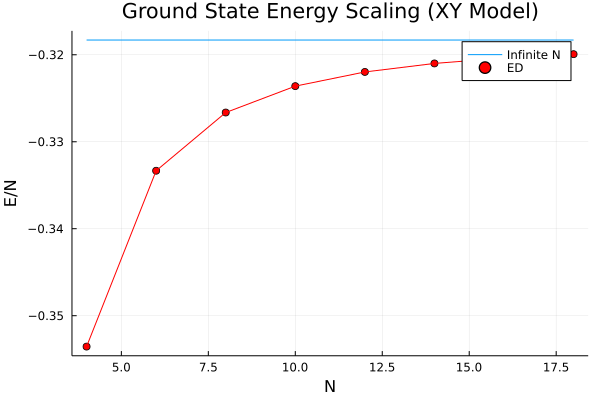

In [9]:
using Plots

plot(title = "Ground State Energy Scaling (XY Model)", xlabel = "N", ylabel = "E/N")

plot!(N_range_new,ground_truth_XY_new,label = "Infinite N")
plot!(N_range_new,gsEs_XY_perN_new,seriestype = :scatter,seriescolor = "red",label = "ED")
display(plot!(N_range_new,gsEs_XY_perN_new,seriescolor = "red",label = false))

In [ ]:
png("NewPlots/XY_gsE_perN")

In [10]:
using LsqFit

model_XY(t,p) = p[1] .+ p[2].*t.^p[3]
#model_XY(t,p) = p[1] .+ p[2].*exp.(-1 .*(t .- p[3]))
#model_XY(t,p) = p[1] .+ p[2]./t
tdata = N_range_new[2:length(N_range_new)]
ydataXY = gsEs_XY_perN_new[2:length(N_range_new)]
p0 = [-1., -1.,-1.]

fit = curve_fit(model_XY, tdata, ydataXY, p0)
paramXY = fit.param

3-element Vector{Float64}:
 -0.31838028263040624
 -0.5978830459970917
 -2.058663550564367

In [11]:
N_range_cont = range(4,20,step = .02);
fit_contXY = paramXY[1] .+ paramXY[2].*N_range_cont.^paramXY[3]
#fit_contXY= paramXY[1] .+ paramXY[2].*exp.(-1 .*(N_range_cont .- paramXY[3]));
#fit_contXY = paramXY[1] .+ paramXY[2]./N_range_cont;

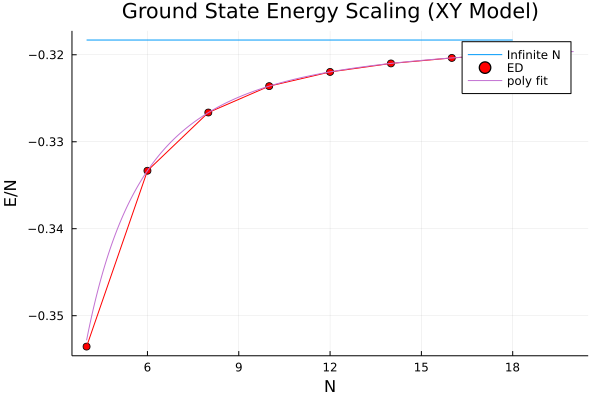

In [12]:
plot!(N_range_cont,fit_contXY,label = "poly fit")

In [ ]:
png("NewPlots/XYpolyfit")

In [13]:
print(paramXY)

[-0.31838028263040624, -0.5978830459970917, -2.058663550564367]

In [14]:
se = standard_errors(fit)

3-element Vector{Float64}:
 1.2023270390746998e-5
 0.0042607289613305205
 0.004283605378769531

##### The antiferromagnetic Heisenberg Model

Perform a finite size scaling extrapolation of several of your largest N to obain an estimate for the ground-state energy.

In [32]:
using Arpack
gsEs_Heis_new = zeros(length(N_range_new))

for i in 1:length(N_range_new)
    N_Heis = N_range_new[i]
    println(N_Heis)
    H_Heis = Build_Sz0_Block(N_Heis,-1,-1)
    gs,vec = eigs(H_Heis,nev=1,which=:SR)
    gsEs_Heis_new[i] = gs[1]
end

4
6
8
10
12
14
16
18


In [ ]:
print(gsEs_Heis_new)

In [34]:
using JLD2
save_object("NewData/Heis_gsEs_prob2_8",gsEs_Heis_new)

In [35]:
using JLD2
gsEs_Heis_new = load_object("NewData/Heis_gsEs_prob2_8")

8-element Vector{Float64}:
 -2.0
 -2.802775637731995
 -3.6510934089371734
 -4.515446354492042
 -5.387390917445198
 -6.263549533547041
 -7.142296360616775
 -8.022749087033745

In [40]:
gsEs_Heis_perN_new = zeros(length(gsEs_Heis_new))

for i in 1:length(gsEs_Heis_new)
    gsEs_Heis_perN_new[i] = gsEs_Heis_new[i]/N_range_new[i]
end

ground_truth_Heis_new = ones(length(N_range_new)).*((1/4)-log(2))

8-element Vector{Float64}:
 -0.4431471805599453
 -0.4431471805599453
 -0.4431471805599453
 -0.4431471805599453
 -0.4431471805599453
 -0.4431471805599453
 -0.4431471805599453
 -0.4431471805599453

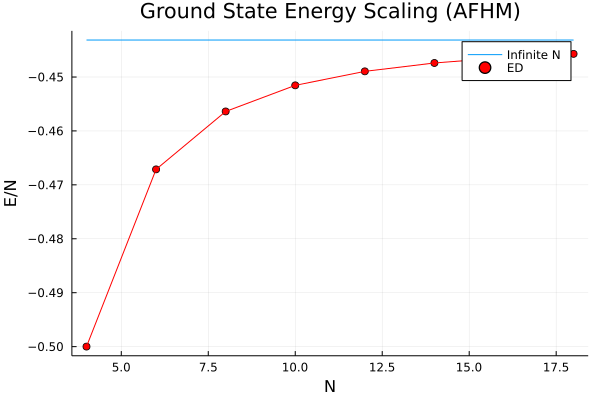

In [41]:
using Plots

plot(title = "Ground State Energy Scaling (AFHM)", xlabel = "N", ylabel = "E/N")

plot!(N_range_new,ground_truth_Heis_new,label = "Infinite N")
plot!(N_range_new,gsEs_Heis_perN_new,seriestype = :scatter,seriescolor = "red",label = "ED")
display(plot!(N_range_new,gsEs_Heis_perN_new,seriescolor = "red",label = false))

In [ ]:
png("NewPlots/Heis_gsE_perN")

In [42]:
using LsqFit

model_Heis(t,p) = p[1] .+ p[2].*t.^p[3]
#model_Heis(t,p) = p[1] .+ p[2].*exp.(-1 .*(t .- p[3]))
#model_Heis(t,p) = p[1] .+ p[2]./t
tdata = N_range_new[2:length(N_range_new)]
ydataHeis = gsEs_Heis_perN_new[2:length(N_range_new)]
p0 = [-1., -1.,-1.]

fit = curve_fit(model_Heis, tdata, ydataHeis, p0)
paramHeis = fit.param

3-element Vector{Float64}:
 -0.4432843372436245
 -0.9841152027472625
 -2.076367670776783

In [43]:
se = standard_errors(fit)

3-element Vector{Float64}:
 2.2879869833385562e-5
 0.008509973493567963
 0.005189670443342771

In [44]:
N_range_cont = range(4,20,step = .02);
fit_contHeis = paramHeis[1] .+ paramHeis[2].*N_range_cont.^paramHeis[3]
#fit_contHeis= paramHeis[1] .+ paramHeis[2].*exp.(-1 .*(N_range_cont .- paramHeis[3]));
#fit_contXY = paramHeis[1] .+ paramHeis[2]./N_range_cont;

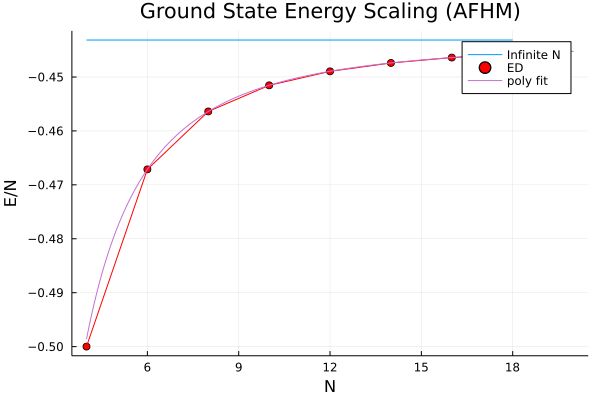

In [45]:
plot!(N_range_cont,fit_contHeis,label = "poly fit")

In [ ]:
png("NewPlots/Heispolyfit")